In [8]:
import sys
import os
import pickle


sys.path.append(os.path.dirname(os.getcwd()))



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [9]:
sys.path.append("C:/Users/Hp/Desktop/ProyectoML_churn")

from src.utils.functions import prepare_data , load_and_preprocess_data, evaluate_classifier, plot_confusion_matrix, plot_roc_curve


Division train, test

In [10]:
path = 'C:/Users/Hp/Desktop/ProyectoML_churn/src/data/processed/df_clean.csv'

df_clean = pd.read_csv(path)

In [11]:
df_clean

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Contract Length,Total Spend,Last Interaction,Churn,dataset,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_cod
0,0.255319,39.0,14.0,0.5,0.600000,Annual,0.924444,0.551724,1.0,train,0,0,1,1
1,1.000000,49.0,1.0,1.0,0.266667,Monthly,0.507778,0.172414,1.0,train,0,0,0,0
2,0.787234,14.0,4.0,0.6,0.600000,Quarterly,0.094444,0.068966,1.0,train,0,0,0,1
3,0.851064,38.0,21.0,0.7,0.233333,Monthly,0.328889,0.965517,1.0,train,1,0,1,0
4,0.106383,32.0,20.0,0.5,0.266667,Monthly,0.574444,0.655172,1.0,train,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492417,0.574468,33.0,12.0,0.6,0.700000,Quarterly,0.941111,0.448276,1.0,test,0,0,0,1
492418,0.404255,6.0,1.0,0.5,0.733333,Annual,0.914444,0.275862,1.0,test,1,0,1,1
492419,0.148936,39.0,14.0,0.8,1.000000,Monthly,0.252222,0.655172,1.0,test,1,1,0,0
492420,0.680851,18.0,19.0,0.7,0.733333,Monthly,0.488889,0.413793,1.0,test,0,0,1,0


In [12]:
X_train, y_train, X_test, y_test = prepare_data(df_clean)


Hiperparametros

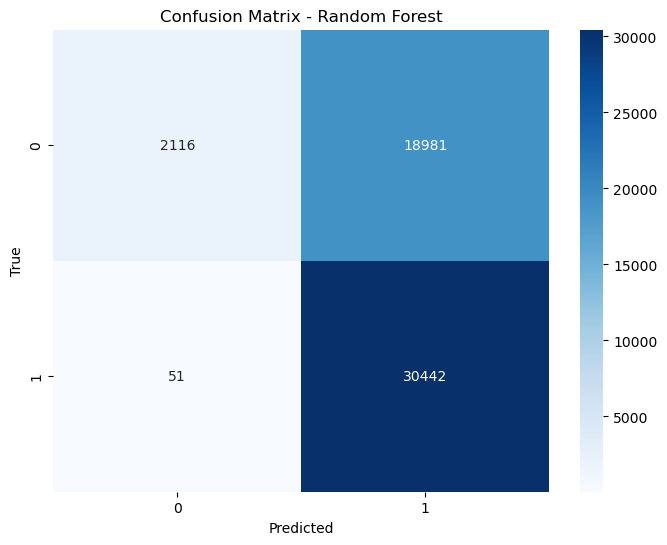

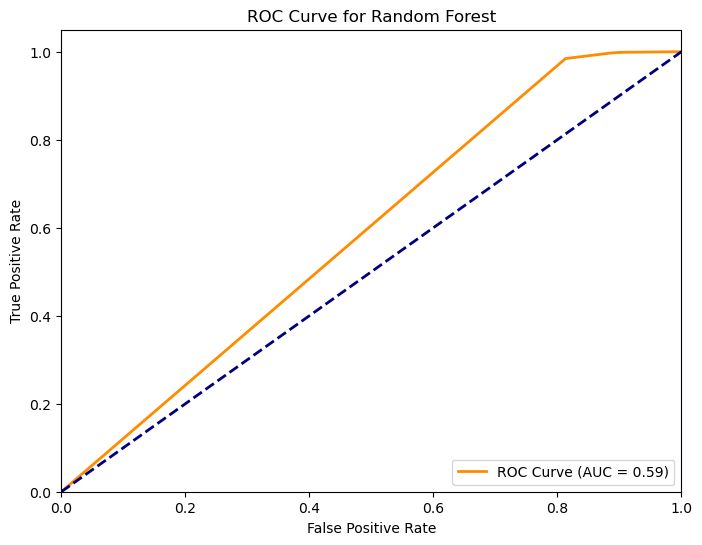

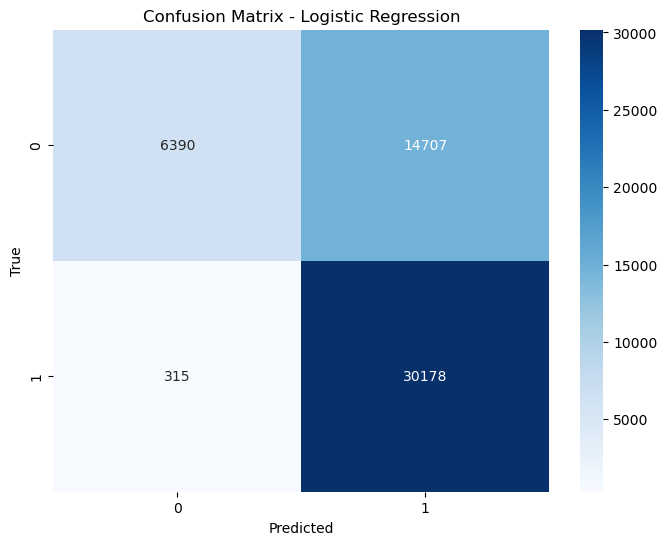

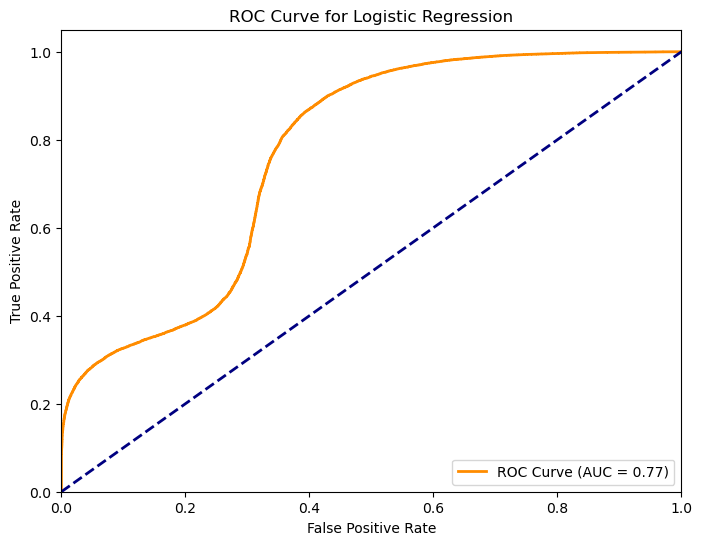

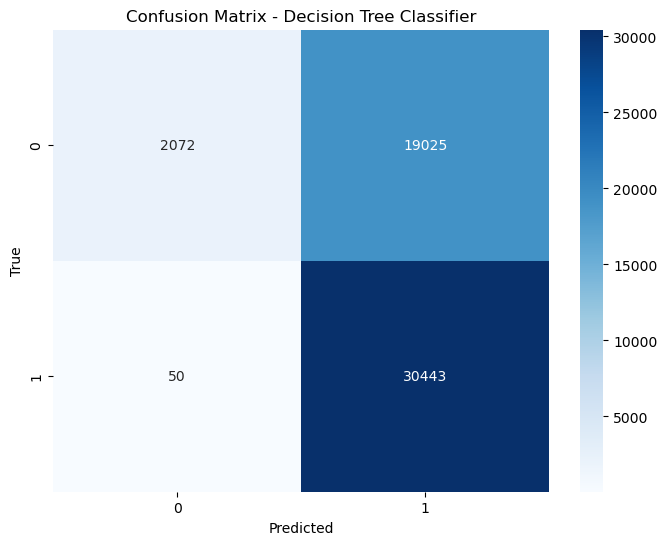

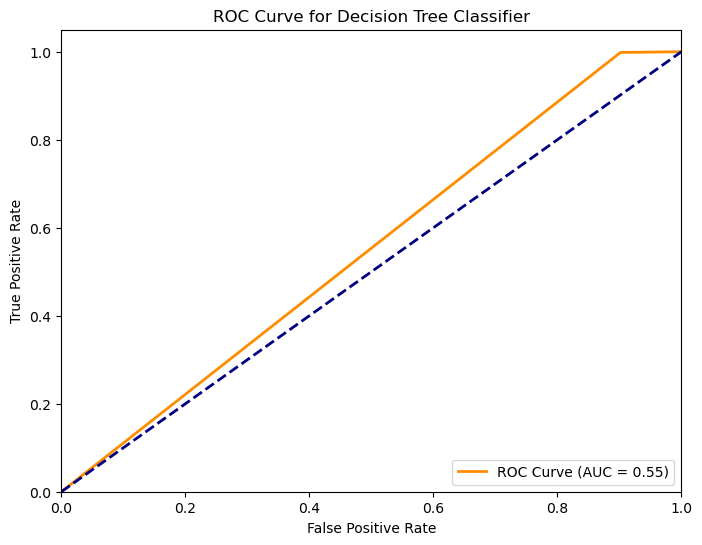

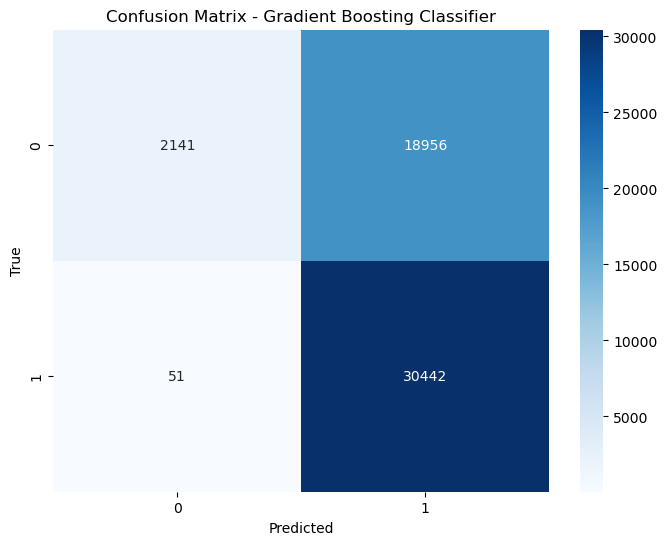

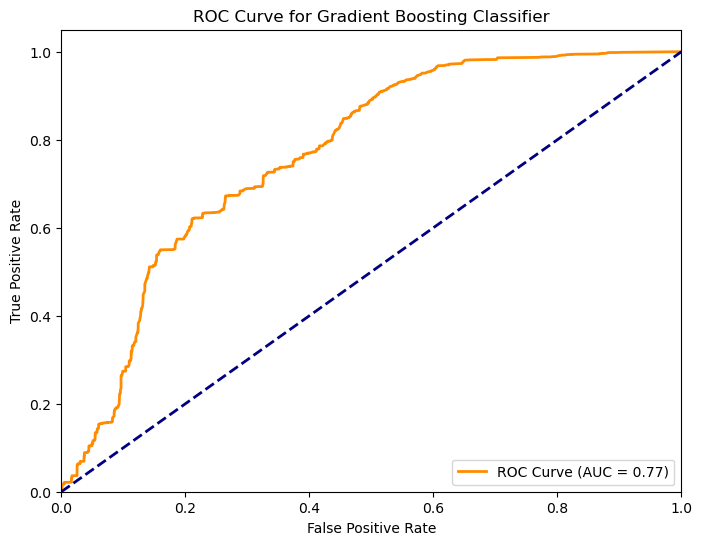

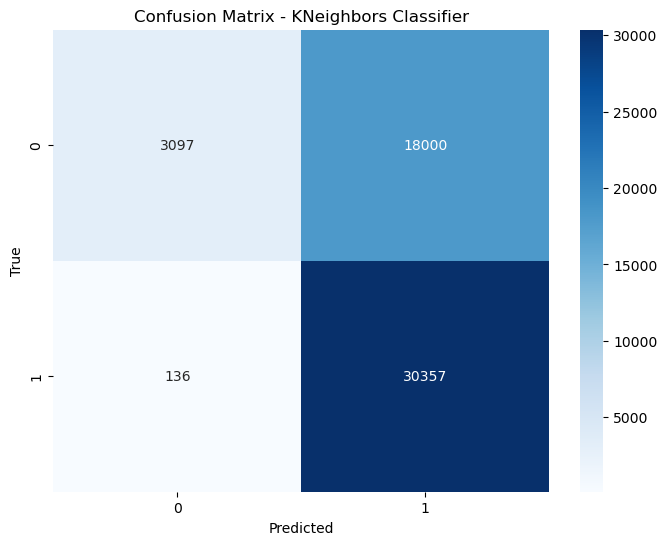

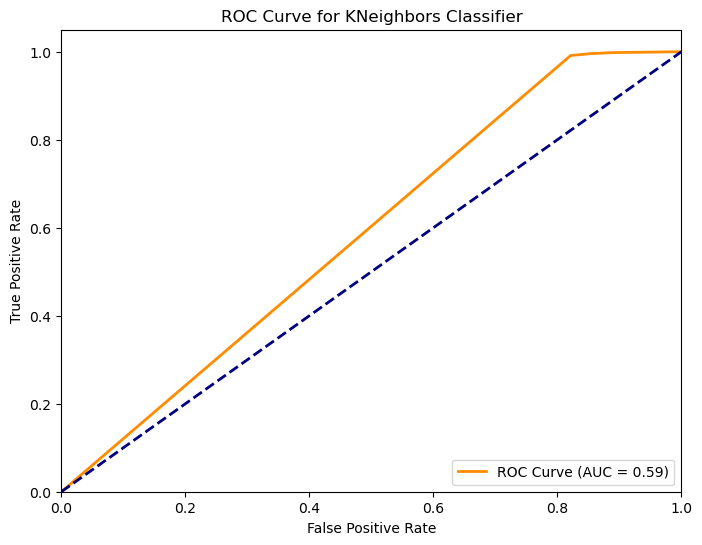

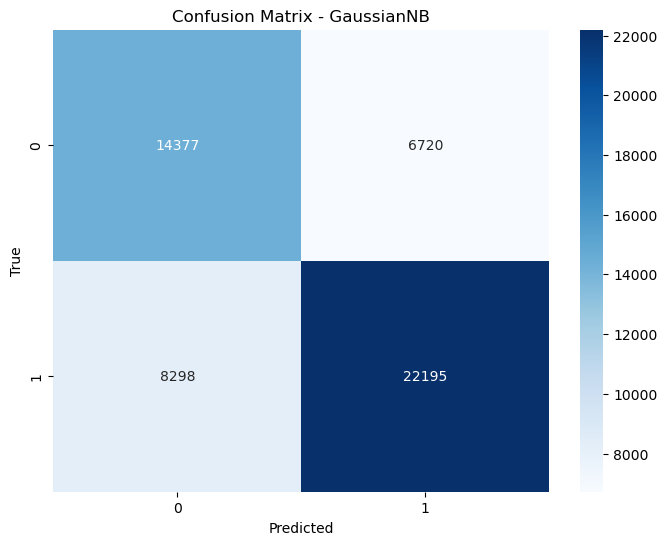

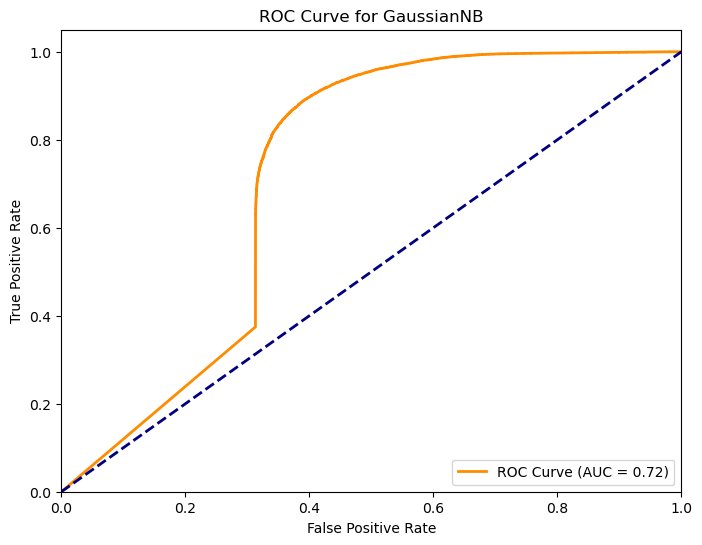

                          Model  Accuracy  Precision    Recall  F1 Score
0                 Random Forest  0.631091   0.615948  0.998327  0.761850
1           Logistic Regression  0.708820   0.672340  0.989670  0.800711
2      Decision Tree Classifier  0.630258   0.615408  0.998360  0.761446
3  Gradient Boosting Classifier  0.631576   0.616260  0.998327  0.762088
4         KNeighbors Classifier  0.648459   0.627768  0.995540  0.769994
5                    GaussianNB  0.708897   0.767595  0.727872  0.747206


In [13]:
models = [
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree Classifier", DecisionTreeClassifier(random_state=42)),
    ("Gradient Boosting Classifier", GradientBoostingClassifier(random_state=42)),
    ("KNeighbors Classifier", KNeighborsClassifier()),
    ("GaussianNB", GaussianNB())
]


results = []

for model_name, model in models:
    results.append({
        "Model": model_name,
        **evaluate_classifier(model, X_train, y_train, X_test, y_test)
    })

    
    plot_confusion_matrix(y_test, model.predict(X_test), f'Confusion Matrix - {model_name}')
    plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1], model_name)

results_df = pd.DataFrame(results)
print(results_df)


In [14]:
# Hyperparameters for RandomForest
param_grid_rf = {
    'max_depth': [80, 90, 100, 110]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

best_param_rf = grid_rf.best_params_

print(best_param_rf)

rf_best = RandomForestClassifier(random_state=42, **best_param_rf)
rf_best.fit(X_train, y_train)

y_pred_rf_best = rf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf_best)
classification_report_rf = classification_report(y_test, y_pred_rf_best)

print(f'Accuracy: {accuracy}')
print(classification_report_rf)


# Hyperparameters for DecisionTreeClassifier
param_grid_dt = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.1, .01, .001],
    'max_depth': [5, 6, 7, 8, 9],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = RandomizedSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_param_dt = grid_dt.best_params_

print(best_param_dt)

dt_best = DecisionTreeClassifier(random_state=42, **best_param_dt)
dt_best.fit(X_train, y_train)

y_pred_dt_best = dt_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dt_best)
classification_report_dt = classification_report(y_test, y_pred_dt_best)

print(f'Accuracy: {accuracy}')
print(classification_report_dt)

# Hyperparameters for Logistic Regression
param_grid_lr = [
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 1000, 2500, 5000]
    }
]

lr = LogisticRegression(random_state=42)

grid_lr = RandomizedSearchCV(lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_param_lr = grid_lr.best_params_

print(best_param_lr)

lr_best = LogisticRegression(random_state=42, **best_param_lr)
lr_best.fit(X_train, y_train)

y_pred_lr_best = lr_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr_best)
classification_report_lr = classification_report(y_test, y_pred_lr_best)

print(f'Accuracy: {accuracy}')
print(classification_report_lr)



# Hyperparameters for KNeighbors Classifier
param_grid_knn = {
    'n_neighbors': (1, 10, 1),
    'leaf_size': (20, 40, 1),
    'p': (1, 2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}

knn = KNeighborsClassifier()

grid_knn = RandomizedSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_param_knn = grid_knn.best_params_

print(best_param_knn)

knn_best = KNeighborsClassifier(**best_param_knn)
knn_best.fit(X_train, y_train)

y_pred_knn_best = knn_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn_best)
classification_report_knn = classification_report(y_test, y_pred_knn_best)

print(f'Accuracy: {accuracy}')
print(classification_report_knn)


# Hyperparameters for Gradient Boosting
param_grid_gb = {
    "criterion": ["friedman_mse", "mae"],
    "loss": ["deviance", "exponential"],
    "max_features": ["log2", "sqrt"],
    'learning_rate': [0.01, 0.05, 0.1, 1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [5, 10, 15, 20]
}

gb = GradientBoostingClassifier(random_state=42)

grid_gb = RandomizedSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)

best_param_gb = grid_gb.best_params_

print(best_param_gb)

gb_best = GradientBoostingClassifier(random_state=42, **best_param_gb)
gb_best.fit(X_train, y_train)

y_pred_gb_best = gb_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb_best)
classification_report_gb = classification_report(y_test, y_pred_gb_best)

print(f'Accuracy: {accuracy}')
print(classification_report_gb)




c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'max_depth': 80}
Accuracy: 0.6310912967629385
              precision    recall  f1-score   support

         0.0       0.98      0.10      0.18     21097
         1.0       0.62      1.00      0.76     30493

    accuracy                           0.63     51590
   macro avg       0.80      0.55      0.47     51590
weighted avg       0.76      0.63      0.52     51590



c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_cons

{'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini', 'ccp_alpha': 0.001}
Accuracy: 0.6496414033727467
              precision    recall  f1-score   support

         0.0       0.94      0.15      0.26     21097
         1.0       0.63      0.99      0.77     30493

    accuracy                           0.65     51590
   macro avg       0.78      0.57      0.52     51590
weighted avg       0.75      0.65      0.56     51590



c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    s

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 206.913808111479}
Accuracy: 0.7088001550688118
              precision    recall  f1-score   support

         0.0       0.95      0.30      0.46     21097
         1.0       0.67      0.99      0.80     30493

    accuracy                           0.71     51590
   macro avg       0.81      0.65      0.63     51590
weighted avg       0.79      0.71      0.66     51590

{'weights': 'distance', 'p': 2, 'n_neighbors': 1, 'metric': 'minkowski', 'leaf_size': 1}
Accuracy: 0.6423337856173678
              precision    recall  f1-score   support

         0.0       0.96      0.13      0.23     21097
         1.0       0.62      1.00      0.77     30493

    accuracy                           0.64     51590
   macro avg       0.79      0.56      0.50     51590
weighted avg       0.76      0.64      0.55     51590



c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_cons

{'subsample': 0.8, 'n_estimators': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'exponential', 'learning_rate': 1, 'criterion': 'friedman_mse'}
Accuracy: 0.6349098662531498
              precision    recall  f1-score   support

         0.0       0.97      0.11      0.20     21097
         1.0       0.62      1.00      0.76     30493

    accuracy                           0.63     51590
   macro avg       0.80      0.55      0.48     51590
weighted avg       0.76      0.63      0.53     51590



In [38]:

# Tu modelo
modelo_lr_mejor = lr_mejor

# Ruta al archivo donde deseas guardar el modelo .pkl
ruta_archivo_pkl_lr = "C:/Users/Hp/Desktop/proyecto/src/models/modelo_lr_mejor.pkl"

# Guarda el modelo en el archivo .pkl
with open(ruta_archivo_pkl_lr, 'wb') as archivo_pkl:
    pickle.dump(modelo_lr_mejor, archivo_pkl)